In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import chain
import scipy.misc
import scipy.signal
from scipy import ndimage
import time
import os
import pickle
import cPickle
from matplotlib.colors import LogNorm

!jupyter nbconvert --to script cluster_sizes.ipynb
import event_converter
import cluster_sizes
reload(event_converter)
reload(cluster_sizes)
from event_converter import *
from cluster_sizes import *

print 'Done.'

[NbConvertApp] Converting notebook cluster_sizes.ipynb to script
[NbConvertApp] Writing 11571 bytes to cluster_sizes.py
[NbConvertApp] Converting notebook event_converter.ipynb to script
[NbConvertApp] Writing 2675 bytes to event_converter.py


<IPython.core.display.Javascript object>

Done.


In [23]:
def cl_tots_path_and_filename(eta, phi):
    return ('data/cluster_tots/' + str(eta) + '/', str(phi) + '.dat')

def load_cluster_tots(eta, phi):
    path, filename = cl_tots_path_and_filename(eta, phi)
    
    cluster_tots = {}
    hits = get_hits(eta, phi)
    for eventID, positions in cl_positions.iteritems():
        cluster_tots_arr = []
        tot = get_tot_image(hits, eventID)
        for (x1, y1, x2, y2) in positions:
            cluster_tot = tot[x1:x2+1, y1:y2+1]
            ids = np.where(cluster_tot > 0)
            cluster_tots_arr.append(cluster_tot)
        cluster_tots[eventID] = cluster_tots_arr

    if not os.path.exists(path):
        os.makedirs(path)
    outfile = open(path + filename, 'wb')
    cPickle.dump(cluster_tots, outfile, protocol=pickle.HIGHEST_PROTOCOL)
    outfile.close()
    return cluster_tots

def get_cluster_tots(eta, phi):
    path, filename = cl_tots_path_and_filename(eta, phi)
    if not os.path.exists(path + filename):
        return load_cluster_tots(eta, phi)
    else:
        infile = open(path + filename, 'r')
        data = cPickle.load(infile)
        infile.close
        return data   

eta: 1 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 2 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 3 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 4 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 5 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 6 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 7 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 8 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 9 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 10 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 11 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 12 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 13 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 14 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 15 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 16 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 17 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 18 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 19 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 20 phi: 0 1 2 3 4 5 6 7 8 9 10 11 1

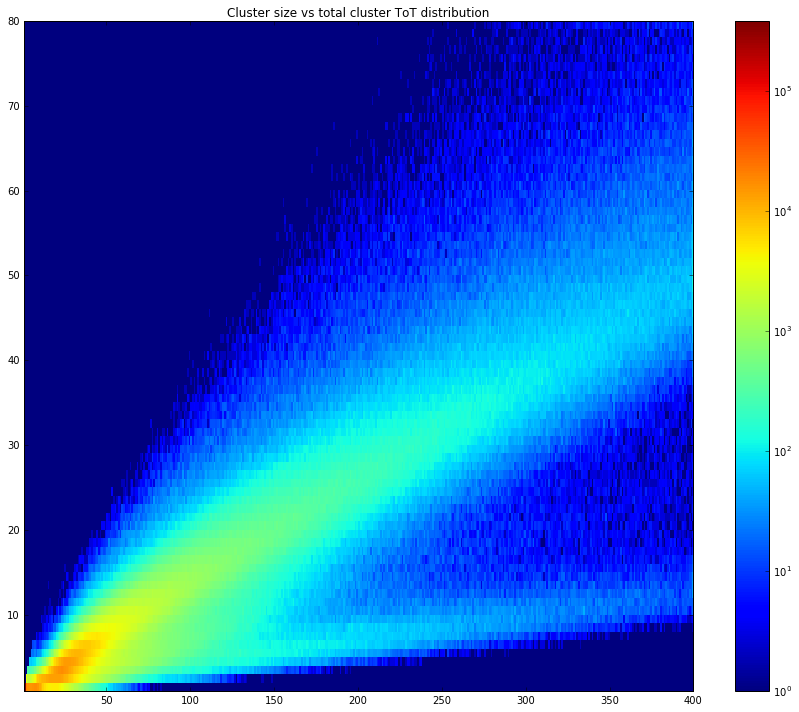

In [25]:
tot_size = []

for eta_i in range(1, 31):
    print 'eta:', eta_i, 'phi:', 
    for phi_i in range(0, 16):
        print phi_i,
        cl_positions = cluster_positions(eta_i, phi_i)
        cluster_tots = get_cluster_tots(eta_i, phi_i)
        for eventID, positions in cl_positions.iteritems():
            for (i, (x1, y1, x2, y2)) in enumerate(positions):
                cluster_tot = cluster_tots[eventID][i]
                total_tot = np.sum(cluster_tot)
                num_hits = len(np.where(cluster_tot > 0)[0])
                tot_size.append((num_hits, total_tot))
    print
    
tot_size = np.array(tot_size)

print tot_size.shape, np.mean(tot_size, axis=0), np.std(tot_size, axis=0)

plt.figure(figsize=(15, 12))
plt.title('Cluster size vs total cluster ToT distribution')
H, yedges, xedges = np.histogram2d(tot_size[:, 0], tot_size[:, 1], bins=(range(1, 81), range(1, 401)))
norm = LogNorm(1, H.max())
plt.imshow(np.clip(H, 1, H.max()), norm=norm, interpolation='nearest', origin='low', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.colorbar()
plt.axis('tight')
plt.savefig('cluster_size_vs_tot.png')

eta: 1 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 2 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 3 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 4 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 5 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 6 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 7 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 8 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 9 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 10 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 11 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 12 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 13 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 14 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 15 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 16 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 17 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 18 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 19 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 20 phi: 0 1 2 3 4 5 6 7 8 9 10 11 1

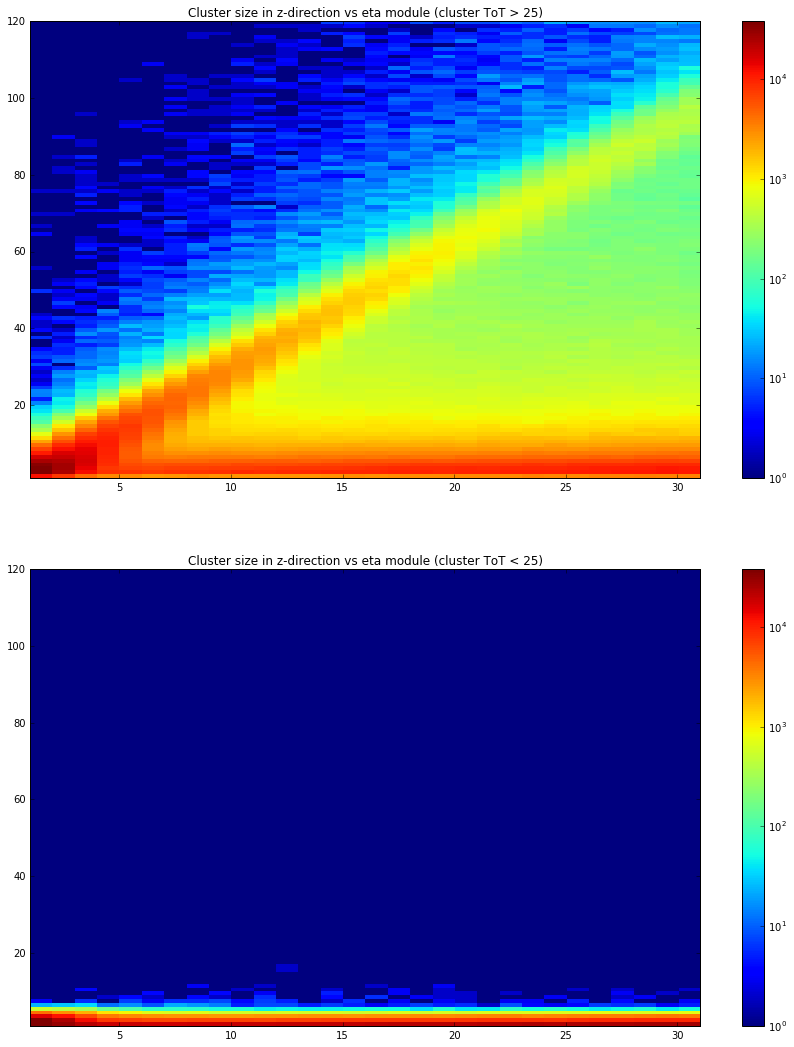

In [49]:
def cluster_sizes_for_eta_with_filter(eta, min=0, max=9e99):
    print 'eta:', eta, 'phi:',
    sizes = np.zeros((0,2))
    sizes2 = np.zeros((0,2))
    for phi_i in range(0, 16):
        print phi_i,
        cl_positions = cluster_positions(eta, phi_i)
        cluster_tots = get_cluster_tots(eta, phi_i)
        for eventID, positions in cl_positions.iteritems():
            tots = np.array([np.sum(cluster_tots[eventID][i]) for (i, _) in enumerate(positions)])
            sz = cluster_sizes(positions[np.where((tots > min) & (tots <= max))[0], :])
            sz2 = cluster_sizes(positions[np.where((tots <= min) | (tots > max))[0], :])
            sizes = np.vstack([sizes, sz])
            sizes2 = np.vstack([sizes2, sz2])
    print
    return (sizes, sizes2)

def show_length_heatmap_per_eta(eta1, eta2, filter):
    plt.figure(figsize=(15, 18))
    
    eta_lengths = []
    eta_lengths2 = []
    for eta_i in range(eta1, eta2+1):
        sizes, sizes2 = cluster_sizes_for_eta_with_filter(eta_i, min=filter)
        sizes[:, 0] = eta_i
        sizes2[:, 0] = eta_i
        eta_lengths.append(sizes)
        eta_lengths2.append(sizes2)

    eta_lengths = np.vstack(eta_lengths)
    eta_lengths2 = np.vstack(eta_lengths2)
    
    plt.subplot(2, 1, 1)
    plt.title('Cluster size in z-direction vs eta module (cluster ToT > ' + str(filter) + ')')
    H, yedges, xedges = np.histogram2d(eta_lengths[:, 1], eta_lengths[:, 0], bins=(range(1, 121), range(1, 32)))
    norm = LogNorm(1, H.max())
    plt.imshow(np.clip(H, 1, H.max()), norm=norm, aspect=0.25, interpolation='nearest', origin='low', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    plt.colorbar()
    plt.axis('tight')

    plt.subplot(2, 1, 2)
    plt.title('Cluster size in z-direction vs eta module (cluster ToT < ' + str(filter) + ')')
    H, yedges, xedges = np.histogram2d(eta_lengths2[:, 1], eta_lengths2[:, 0], bins=(range(1, 121), range(1, 32)))
    norm = LogNorm(1, H.max())
    plt.imshow(np.clip(H, 1, H.max()), norm=norm, aspect=0.25, interpolation='nearest', origin='low', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    plt.colorbar()
    plt.axis('tight')

    plt.savefig('cluster_length_eta_tot_split_' + str(filter) + '.png')

show_length_heatmap_per_eta(1, 30, 25)

In [50]:
maxes = []
for eta_i in range(1, 31):
    print 'eta:', eta_i, 'phi:', 
    for phi_i in range(0, 16):
        print phi_i,
        hits = get_hits(eta_i, phi_i)
        events = list(np.unique(hits[2,:]))
        for eventID in events:
            tot = get_tot_image(hits, eventID)
            max_tot = np.max(tot)
            maxes.append(max_tot)
    print
        
print np.mean(maxes), np.std(maxes), np.max(maxes)

eta: 1 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 2 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 3 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 4 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 5 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 6 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 7 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 8 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 9 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 10 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 11 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 12 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 13 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 14 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 15 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 16 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 17 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 18 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 19 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 20 phi: 0 1 2 3 4 5 6 7 8 9 10 11 1